# Importación de librerias

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math 
import numba as nb
from numba import njit

## Codigo normal

In [49]:

## Funcion para definir los nodos de forma aleatoria
def build_system(L, q):
    """Construye el sistema con spins aleatorios en una red BCC 3D diluida"""
    N = 2 * L * L * L
    n = int(q * N)
    Ss = np.zeros((L, L, L, 2), dtype=int)
    posiciones_totales = [(i, j, k, u) for i in range(L) for j in range(L) for k in range(L) for u in range(2)]
    random.shuffle(posiciones_totales)
    posiciones_ocupadas = []
    for m in range(n):
        i, j, k, u = posiciones_totales[m]
        Ss[i, j, k, u] = random.choice([-1, 1])
        posiciones_ocupadas.append((i, j, k, u))
    return Ss, posiciones_ocupadas, n

def get_neighbors(i, j, k, u, L):
    """Retorna los vecinos en la red BCC 3D con condiciones periódicas"""
    if u == 0:  # Sublattice A (corners)
        neighbors = []
        for dx in [-1, 0]:
            for dy in [-1, 0]:
                for dz in [-1, 0]:
                    ni = (i + dx) % L
                    nj = (j + dy) % L
                    nk = (k + dz) % L
                    neighbors.append((ni, nj, nk, 1))
        return neighbors
    else:  # Sublattice B (centers)
        neighbors = []
        for dx in [0, 1]:
            for dy in [0, 1]:
                for dz in [0, 1]:
                    ni = (i + dx) % L
                    nj = (j + dy) % L
                    nk = (k + dz) % L
                    neighbors.append((ni, nj, nk, 0))
        return neighbors

def delta_energy(spin, i, j, k, u, H, J, L):
    """Calcula el cambio de energía al flipear un spin"""
    sigma = spin[i, j, k, u]
    neighbors = get_neighbors(i, j, k, u, L)
    sum_vecinos = sum(spin[ni, nj, nk, nu] for ni, nj, nk, nu in neighbors if spin[ni, nj, nk, nu] != 0)
    energia_local = -J * sigma * sum_vecinos + sigma * H
    return 2 * energia_local

def simulate(L, q, J, H, T, steps_equil=10000, steps_meas=10000, measure_every=100):
    """Simula una realización del sistema usando Monte Carlo (Metropolis)"""
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return 0.0
    suma_spins = np.sum(spin)
    # Fase de equilibración
    for _ in range(steps_equil):
        i, j, k, u = random.choice(occupied)
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        if Delta_E <= 0 or math.exp(-Delta_E / T) > random.random():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] *= -1
    # Fase de medición
    m_samples = []
    for step in range(steps_meas):
        i, j, k, u = random.choice(occupied)
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        if Delta_E <= 0 or math.exp(-Delta_E / T) > random.random():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] *= -1
        if step % measure_every == 0:
            m = suma_spins / n
            m_samples.append(m)
    return np.mean(m_samples)

def simulate_ensemble(L, q, J, H, T, num_realizaciones=10, steps_equil=10000,
                      steps_meas=10000, measure_every=100):
    """Promedia sobre múltiples realizaciones del desorden"""
    m_locals = []
    for _ in range(num_realizaciones):
        m_local = simulate(L, q, J, H, T, steps_equil, steps_meas, measure_every)
        m_locals.append(m_local)
    m_final = np.mean(m_locals)
    error = np.std(m_locals) / np.sqrt(num_realizaciones)
    return m_final, error

L = 10
q = 0.8
J = 1.0
H = 0.0
T = 2.0
num_realizaciones = 10
m, err = simulate_ensemble(L, q, J, H, T, num_realizaciones)
print(f"Magnetización promedio (ensemble): {m} ± {err}")

Magnetización promedio (ensemble): 0.0044962499999999985 ± 0.0029610988511446215


## Optimización con numba

In [50]:
## Código optimizado con Numba para red BCC 3D

def build_system(L, q):
    """Construye el sistema con spins aleatorios en una red BCC 3D diluida"""
    N = 2 * L * L * L
    n = int(q * N)
    Ss = np.zeros((L, L, L, 2), dtype=np.int32)
    if n == 0:
        return Ss, np.zeros((0, 4), dtype=np.int32), 0
    
    # Generar todas las posiciones
    i_coords = np.repeat(np.arange(L), L * L * 2)
    j_coords = np.tile(np.repeat(np.arange(L), L * 2), L)
    k_coords = np.tile(np.repeat(np.arange(L), 2), L * L)
    u_coords = np.tile(np.arange(2), L * L * L)
    all_pos = np.column_stack((i_coords, j_coords, k_coords, u_coords))
    
    # Seleccionar posiciones ocupadas aleatoriamente
    idx = np.random.choice(N, n, replace=False)
    posiciones_ocupadas = all_pos[idx]
    
    # Asignar spins aleatorios
    signs = np.random.choice(np.array([-1, 1], dtype=np.int32), n)
    Ss[posiciones_ocupadas[:, 0], posiciones_ocupadas[:, 1], 
       posiciones_ocupadas[:, 2], posiciones_ocupadas[:, 3]] = signs
    
    return Ss, posiciones_ocupadas, n

@njit
def delta_energy(spin, i, j, k, u, H, J, L):
    """Calcula el cambio de energía al flipear un spin"""
    sigma = spin[i, j, k, u]
    sum_vecinos = 0
    
    if u == 0:  # Sublattice A (corners)
        # 8 vecinos en sublattice B (centers)
        for dx in [-1, 0]:
            for dy in [-1, 0]:
                for dz in [-1, 0]:
                    ni = (i + dx) % L
                    nj = (j + dy) % L
                    nk = (k + dz) % L
                    if spin[ni, nj, nk, 1] != 0:
                        sum_vecinos += spin[ni, nj, nk, 1]
    else:  # Sublattice B (centers)
        # 8 vecinos en sublattice A (corners)
        for dx in [0, 1]:
            for dy in [0, 1]:
                for dz in [0, 1]:
                    ni = (i + dx) % L
                    nj = (j + dy) % L
                    nk = (k + dz) % L
                    if spin[ni, nj, nk, 0] != 0:
                        sum_vecinos += spin[ni, nj, nk, 0]
    
    energia_local = -J * sigma * sum_vecinos + sigma * H
    return 2 * energia_local

@njit
def equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """Fase de equilibración del sistema"""
    for _ in range(steps_equil):
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] = -spin[i, j, k, u]
    
    return suma_spins

@njit
def measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """Fase de medición del sistema"""
    num_samples = (steps_meas // measure_every) + 1 if steps_meas % measure_every != 0 else (steps_meas // measure_every)
    m_samples = np.zeros(num_samples)
    cnt = 0
    
    for step in range(steps_meas):
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] = -spin[i, j, k, u]
        
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    
    return m_samples[:cnt]

def simulate(L, q, J, H, T, steps_equil=10000, steps_meas=10000, measure_every=100):
    """Simula una realización del sistema usando Monte Carlo (Metropolis)"""
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return 0.0
    
    # ✅ Calcular suma solo de spins ocupados
    suma_spins = 0
    for idx in range(n):
        i, j, k, u = occupied[idx]
        suma_spins += spin[i, j, k, u]
    
    # Fase de equilibración
    suma_spins = equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
    
    # Fase de medición
    m_samples = measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
    
    return np.mean(m_samples)

def simulate_ensemble(L, q, J, H, T, num_realizaciones=10, steps_equil=10000,
                      steps_meas=10000, measure_every=100):
    """Promedia sobre múltiples realizaciones del desorden"""
    m_locals = []
    for _ in range(num_realizaciones):
        m_local = simulate(L, q, J, H, T, steps_equil, steps_meas, measure_every)
        m_locals.append(m_local)
    
    m_final = np.mean(m_locals)
    error = np.std(m_locals) / np.sqrt(num_realizaciones)
    return m_final, error

# ============ PRUEBA ============
L = 10
q = 0.8
J = 1.0
H = 0.0
T = 2.0
num_realizaciones = 10

print("⏳ Ejecutando simulación optimizada con Numba...")
m, err = simulate_ensemble(L, q, J, H, T, num_realizaciones)
print(f"✅ Magnetización promedio (ensemble): {m:.6f} ± {err:.6f}")

⏳ Ejecutando simulación optimizada con Numba...


✅ Magnetización promedio (ensemble): 0.002365 ± 0.001186


## Graficas de m vs H

🔄 Iniciando simulaciones m vs H para red BCC 3D...


✅ Simulaciones completadas



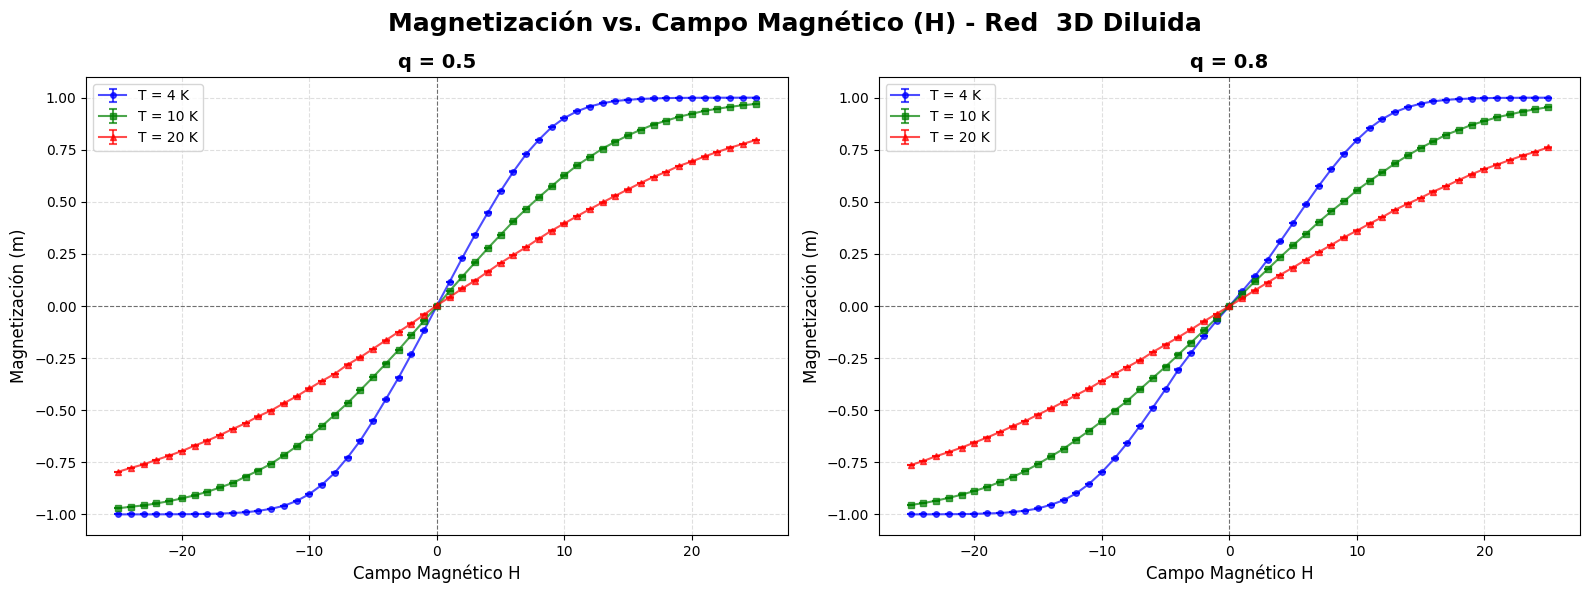

In [51]:
### Gráficas de Magnetización vs Campo Magnético (H) - Red BCC 3D

# --- Parámetros de simulación ---
L = 10
J = 1.0
H_values = np.linspace(-25, 25, 51)  # 51 puntos
q_values = [0.5, 0.8]
T_values = [4, 10, 20]
num_realizaciones = 20
steps_equil = 10000
steps_meas = 20000
measure_every = 100

print("🔄 Iniciando simulaciones m vs H para red BCC 3D...")

# Diccionario para almacenar resultados
results = {}

# --- Simulación ---
for q in q_values:
    for T in T_values:
        magnetizations = []
        errors = []
        
        for H in H_values:
            m, err = simulate_ensemble(
                L=L, q=q, J=J, H=H, T=T,
                num_realizaciones=num_realizaciones,
                steps_equil=steps_equil,
                steps_meas=steps_meas,
                measure_every=measure_every
            )
            magnetizations.append(m)
            errors.append(err)
        
        results[(q, T)] = {'m': magnetizations, 'err': errors}

print("✅ Simulaciones completadas\n")

# --- Visualización: 2 gráficas (una por q) ---
fig, axes = plt.subplots(1, len(q_values), figsize=(16, 6))
fig.suptitle('Magnetización vs. Campo Magnético (H) - Red  3D Diluida', 
             fontsize=18, fontweight='bold')

colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for i, q in enumerate(q_values):
    ax = axes[i]
    
    for j, T in enumerate(T_values):
        res = results[(q, T)]
        ax.errorbar(
            H_values,
            res['m'],
            yerr=res['err'],
            fmt=f'-{markers[j]}',
            markersize=4,
            color=colors[j],
            label=f'T = {T} K',
            capsize=3,
            capthick=1.5,
            elinewidth=1.5,
            alpha=0.7
        )
    
    ax.set_title(f'q = {q}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Campo Magnético H', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='best', fontsize=10)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()


## Codigo para graficar m vs H/T

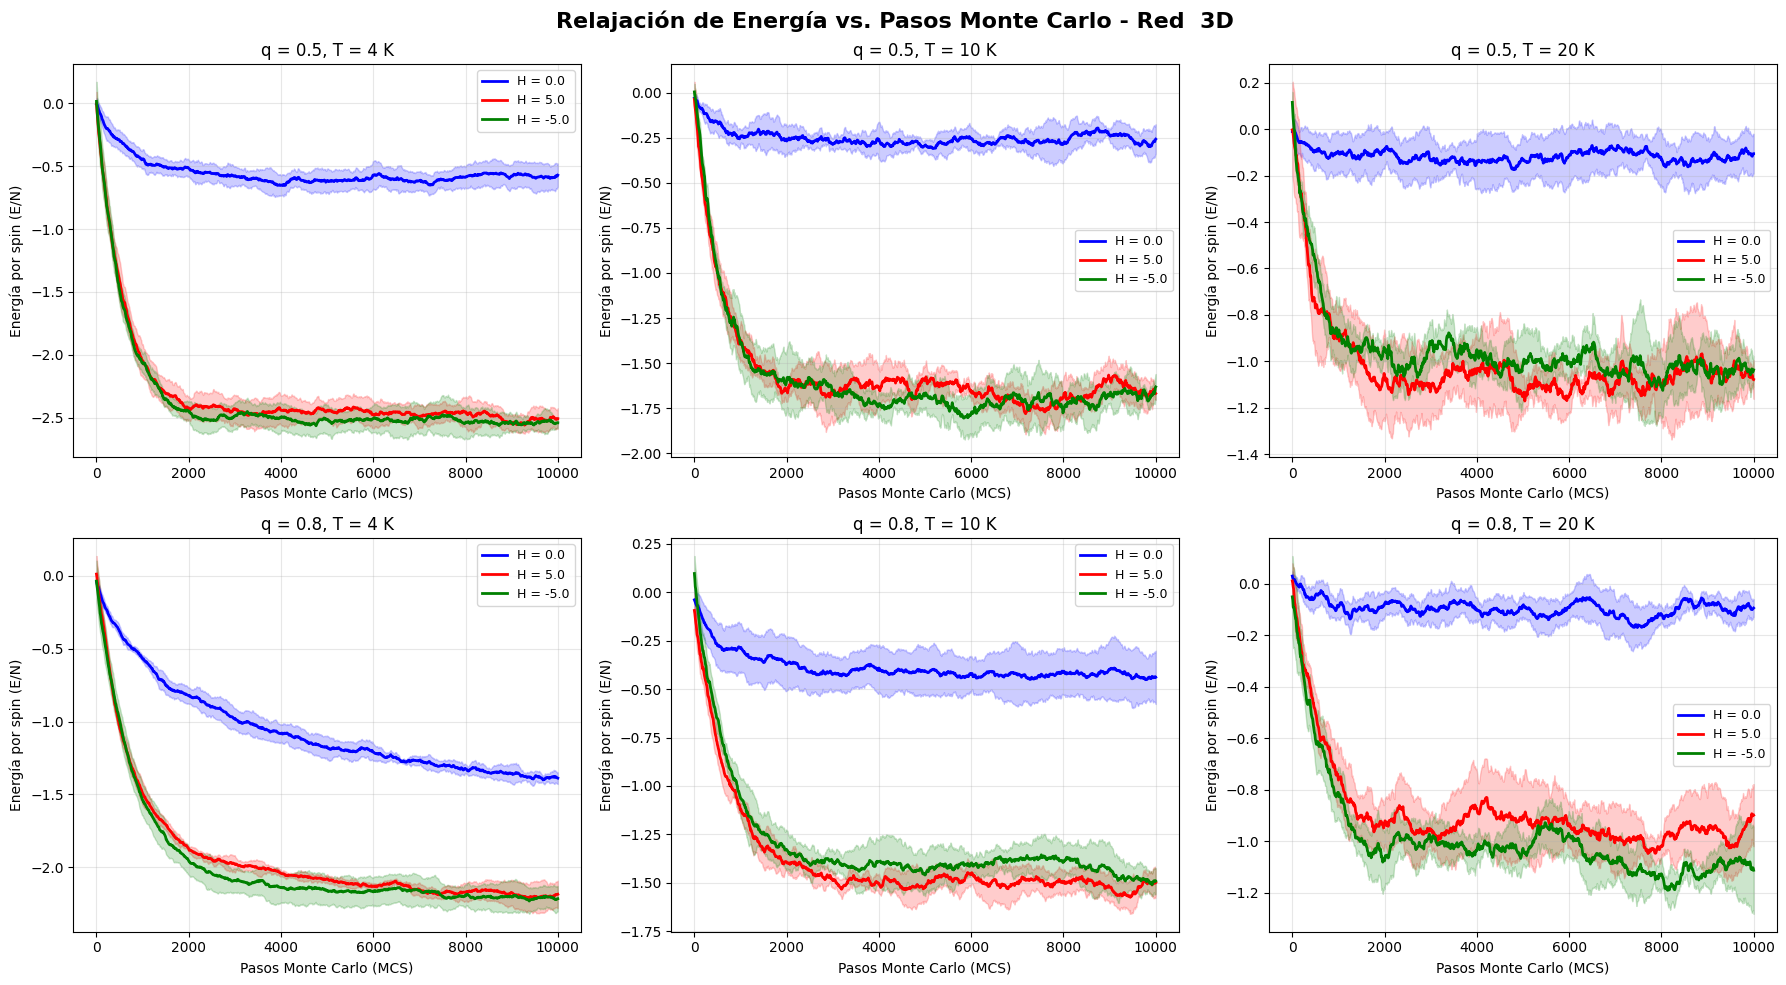

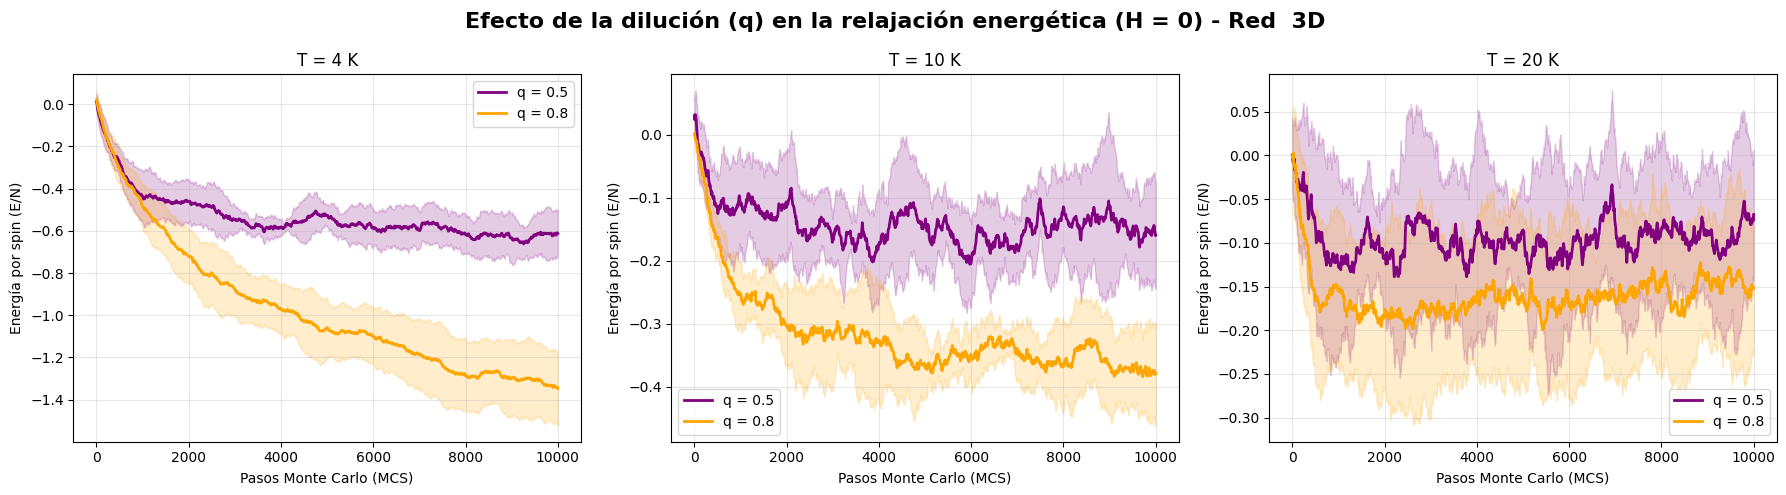

🔄 Calculando m vs. H/T y ajustando a tanh(x) para red BCC 3D...
✅ q=0.5, T=4K: A=1.0021±0.0000, B=0.5874±0.0003, R²=0.9984
✅ q=0.5, T=4K: A=1.0021±0.0000, B=0.5874±0.0003, R²=0.9984
✅ q=0.5, T=10K: A=1.0351±0.0004, B=0.7070±0.0007, R²=0.9999
✅ q=0.5, T=10K: A=1.0351±0.0004, B=0.7070±0.0007, R²=0.9999
✅ q=0.5, T=20K: A=1.0515±0.0021, B=0.7930±0.0022, R²=1.0000
✅ q=0.5, T=20K: A=1.0515±0.0021, B=0.7930±0.0022, R²=1.0000
✅ q=0.8, T=4K: A=1.0126±0.0000, B=0.4425±0.0002, R²=0.9958
✅ q=0.8, T=4K: A=1.0126±0.0000, B=0.4425±0.0002, R²=0.9958
✅ q=0.8, T=10K: A=1.0822±0.0005, B=0.5701±0.0006, R²=0.9999
✅ q=0.8, T=10K: A=1.0822±0.0005, B=0.5701±0.0006, R²=0.9999
✅ q=0.8, T=20K: A=1.0997±0.0029, B=0.6856±0.0024, R²=1.0000

✅ Cálculos y ajustes completados

✅ q=0.8, T=20K: A=1.0997±0.0029, B=0.6856±0.0024, R²=1.0000

✅ Cálculos y ajustes completados



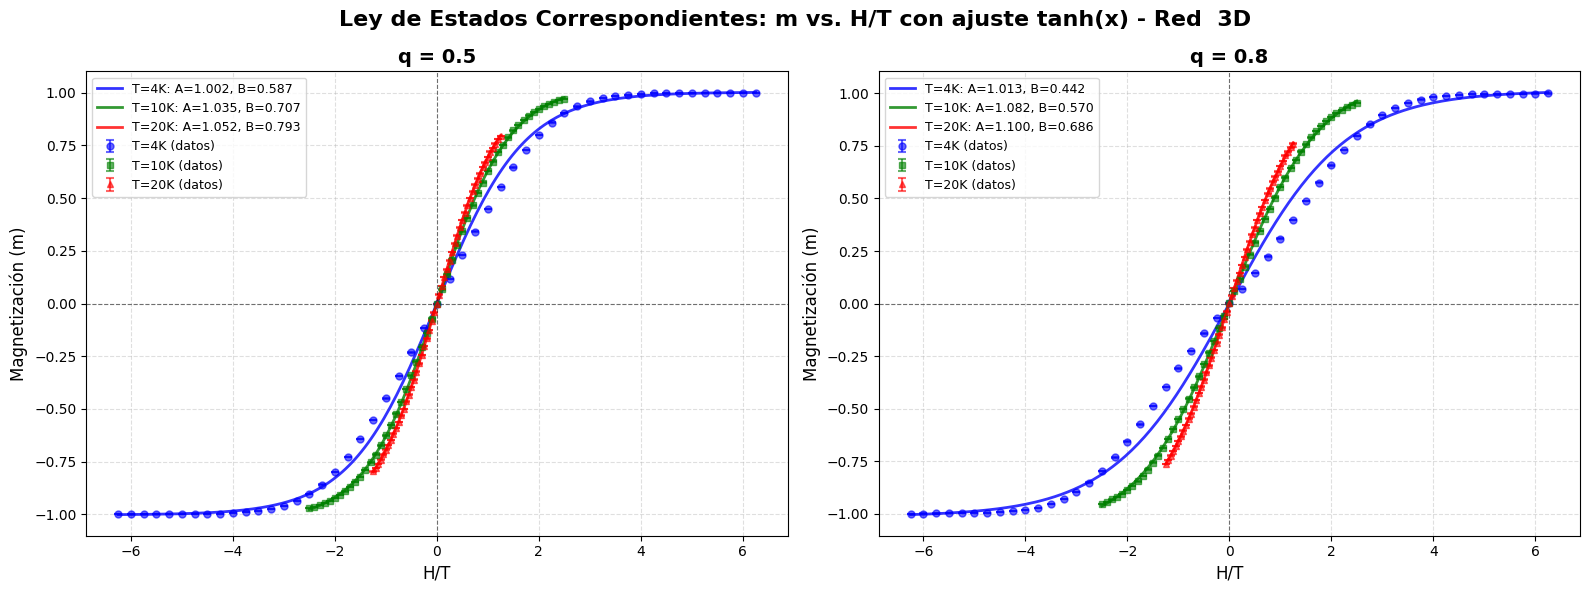


📊 RESUMEN DE PARÁMETROS DE AJUSTE: m = A·tanh(B·H/T) - Red BCC 3D
q      T (K)    A            B            R²        
----------------------------------------------------------------------
0.5    4        1.0021±0.0000  0.5874±0.0003  0.9984
0.5    10       1.0351±0.0004  0.7070±0.0007  0.9999
0.5    20       1.0515±0.0021  0.7930±0.0022  1.0000
0.8    4        1.0126±0.0000  0.4425±0.0002  0.9958
0.8    10       1.0822±0.0005  0.5701±0.0006  0.9999
0.8    20       1.0997±0.0029  0.6856±0.0024  1.0000

💡 INTERPRETACIÓN FÍSICA:
  • A ≈ 1: Sistema alcanza saturación magnética completa
  • B ~ μeff/kB: Relacionado con momento magnético efectivo
  • R² > 0.95: Excelente ajuste al modelo de campo medio
  • Si las curvas colapsan → Ley de Estados Correspondientes verificada
  • Red BCC (z=8): Mayor coordinación → mejor campo medio


In [52]:
### Funciones adicionales para análisis de relajación energética - Red BCC 3D

@njit
def calculate_total_energy(spin, occupied, L, J, H):
    """
    Calcula la energía total del sistema en red BCC 3D
    E = -J * Σ(σi*σj) - H * Σ(σi)
    donde la suma es sobre todos los pares vecinos (8 vecinos por sitio)
    
    Red BCC: Body-Centered Cubic (cúbica centrada en el cuerpo)
    - Sublattice A (u=0): esquinas de la celda (corners)
    - Sublattice B (u=1): centros de la celda (centers)
    - Cada sitio tiene 8 vecinos en la otra sublattice
    
    Args:
        spin: Array 4D de spins (L×L×L×2)
        occupied: Array de posiciones ocupadas (n×4) con coordenadas (i,j,k,u)
        L: Tamaño de la red BCC (L×L×L celdas)
        J: Constante de acoplamiento
        H: Campo magnético externo
    
    Returns:
        energy: Energía total del sistema
    """
    # Calcula el número de sitios ocupados basándose en la forma del array
    n = occupied.shape[0]
    # Inicializa la energía total en cero
    energy = 0.0
    
    # Itera sobre cada sitio ocupado para calcular su contribución energética
    for idx in range(n):
        # Obtiene las coordenadas (i, j, k, u) del sitio ocupado actual
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        # Obtiene el valor del spin en ese sitio
        sigma = spin[i, j, k, u]
        
        # Inicializa la suma de spins vecinos
        sum_vecinos = 0
        
        # Verifica si el sitio está en sublattice A (corners, u=0)
        if u == 0:
            # Tiene 8 vecinos en sublattice B (centers, u=1)
            # Itera sobre las 8 posiciones vecinas: combinaciones de dx,dy,dz ∈ {-1,0}
            for dx in [-1, 0]:
                for dy in [-1, 0]:
                    for dz in [-1, 0]:
                        # Calcula las coordenadas del vecino con condiciones periódicas
                        ni = (i + dx) % L
                        nj = (j + dy) % L
                        nk = (k + dz) % L
                        # Verifica si el vecino está ocupado (spin != 0)
                        if spin[ni, nj, nk, 1] != 0:
                            sum_vecinos += spin[ni, nj, nk, 1]
        else:
            # Está en sublattice B (centers, u=1)
            # Tiene 8 vecinos en sublattice A (corners, u=0)
            # Itera sobre las 8 posiciones vecinas: combinaciones de dx,dy,dz ∈ {0,1}
            for dx in [0, 1]:
                for dy in [0, 1]:
                    for dz in [0, 1]:
                        # Calcula las coordenadas del vecino con condiciones periódicas
                        ni = (i + dx) % L
                        nj = (j + dy) % L
                        nk = (k + dz) % L
                        # Verifica si el vecino está ocupado (spin != 0)
                        if spin[ni, nj, nk, 0] != 0:
                            sum_vecinos += spin[ni, nj, nk, 0]
        
        # Energía de interacción dividida por 2 para evitar contar dos veces cada enlace
        energy += -J * sigma * sum_vecinos / 2.0
        
        # Energía del campo magnético externo (término Zeeman)
        energy += -H * sigma
    
    # Retorna la energía total calculada
    return energy

@njit
def simulate_with_energy_tracking(spin, occupied, L, n, max_steps, H, J, T, record_every=10):
    """
    Simula el sistema y registra la evolución de energía vs pasos Monte Carlo
    
    Args:
        spin: Array 4D de spins inicial (L×L×L×2)
        occupied: Array de posiciones ocupadas (n×4)
        L: Tamaño de la red BCC
        n: Número de sitios ocupados
        max_steps: Número máximo de pasos Monte Carlo
        H: Campo magnético externo
        J: Constante de acoplamiento
        T: Temperatura
        record_every: Frecuencia de registro (cada cuántos pasos se guarda)
    
    Returns:
        mcs_array: Array con los pasos Monte Carlo registrados
        energy_array: Array con las energías registradas
    """
    # Calcula cuántos registros se harán durante la simulación
    num_records = (max_steps // record_every) + 1
    # Crea array para almacenar los pasos Monte Carlo registrados
    mcs_array = np.zeros(num_records)
    # Crea array para almacenar las energías registradas
    energy_array = np.zeros(num_records)
    
    # Calcula la energía inicial del sistema
    energy = calculate_total_energy(spin, occupied, L, J, H)
    # Registra el paso inicial (0)
    mcs_array[0] = 0
    # Registra la energía inicial
    energy_array[0] = energy
    
    # Inicializa el contador de registros
    cnt = 1
    # Itera sobre cada paso Monte Carlo desde 1 hasta max_steps
    for step in range(1, max_steps + 1):
        # Selecciona aleatoriamente un spin ocupado
        idx = np.random.randint(n)
        # Obtiene las coordenadas (i, j, k, u) del spin seleccionado
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        
        # Calcula el cambio de energía si se voltea el spin
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        
        # Criterio de aceptación de Metropolis-Hastings
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            # Acepta el movimiento: voltea el spin
            spin[i, j, k, u] = -spin[i, j, k, u]
            # Actualiza la energía total con el cambio
            energy += Delta_E
        
        # Registra la energía cada 'record_every' pasos
        if step % record_every == 0:
            # Guarda el número de paso Monte Carlo
            mcs_array[cnt] = step
            # Guarda la energía en ese paso
            energy_array[cnt] = energy
            # Incrementa el contador de registros
            cnt += 1
    
    # Retorna los arrays recortados hasta el número real de registros
    return mcs_array[:cnt], energy_array[:cnt]

def run_energy_relaxation(L, q, J, H, T, max_steps=10000, record_every=10):
    """
    Ejecuta una simulación completa y retorna la evolución temporal de la energía
    
    Args:
        L: Tamaño de la red BCC (L×L×L celdas)
        q: Concentración de sitios ocupados
        J: Constante de acoplamiento
        H: Campo magnético externo
        T: Temperatura
        max_steps: Número máximo de pasos Monte Carlo
        record_every: Frecuencia de registro
    
    Returns:
        mcs: Array de pasos Monte Carlo
        energies_per_spin: Array de energía por spin
    """
    # Construye el sistema con configuración inicial aleatoria
    spin, occupied, n = build_system(L, q)
    # Si no hay spins ocupados, retorna arrays con un solo elemento cero
    if n == 0:
        return np.array([0]), np.array([0])
    
    # Ejecuta la simulación con seguimiento de energía
    mcs, energies = simulate_with_energy_tracking(
        spin, occupied, L, n, max_steps, H, J, T, record_every
    )
    
    # Normaliza la energía por el número de spins ocupados
    energies_per_spin = energies / n
    
    # Retorna los pasos Monte Carlo y la energía por spin
    return mcs, energies_per_spin

### Análisis de relajación energética para red BCC 3D

# Define el tamaño de la red BCC (10×10×10 celdas = 2000 sitios)
L = 10
# Define la constante de acoplamiento ferromagnético
J = 1.0
# Define dos valores de concentración de sitios ocupados (50% y 80%)
q_values = [0.5, 0.8]
# Define tres valores de temperatura para las simulaciones (4K, 10K, 20K)
T_values = [4, 10, 20]
# Define tres valores de campo magnético para analizar (0, 5, -5)
H_values_relax = [0.0, 5.0, -5.0]
# Define el número máximo de pasos Monte Carlo (10^4 pasos)
max_steps = 10000
# Define cada cuántos pasos se registra la energía (cada 10 pasos)
record_every = 10
# Define el número de realizaciones del desorden para promediar (5 realizaciones)
num_realizaciones = 5

# Crea figura con subplots: len(q_values) filas x len(T_values) columnas
fig, axes = plt.subplots(len(q_values), len(T_values), figsize=(18, 10))
# Define el título principal de la figura
fig.suptitle('Relajación de Energía vs. Pasos Monte Carlo - Red  3D', fontsize=16, fontweight='bold')

# Define lista de colores para distinguir los tres campos magnéticos
colors_H = ['blue', 'red', 'green']

# Itera sobre cada valor de concentración q con su índice
for i, q in enumerate(q_values):
    # Itera sobre cada valor de temperatura T con su índice
    for j, T in enumerate(T_values):
        # Selecciona el eje correspondiente para esta combinación (q,T)
        ax = axes[i, j]
        
        # Itera sobre cada valor de campo magnético H con su índice
        for idx, H in enumerate(H_values_relax):
            # Crea listas vacías para almacenar resultados de múltiples realizaciones
            all_mcs = []
            all_energies = []
            
            # Ejecuta múltiples realizaciones del desorden
            for _ in range(num_realizaciones):
                # Ejecuta la simulación de relajación energética
                mcs, energies = run_energy_relaxation(L, q, J, H, T, max_steps, record_every)
                # Verifica que se hayan registrado al menos 2 puntos
                if len(mcs) > 1:
                    # Almacena los pasos Monte Carlo
                    all_mcs.append(mcs)
                    # Almacena las energías por spin
                    all_energies.append(energies)
            
            # Si hay datos válidos de las realizaciones
            if all_energies:
                # Calcula la energía promedio sobre todas las realizaciones
                mean_energies = np.mean(all_energies, axis=0)
                # Calcula la desviación estándar de las energías
                std_energies = np.std(all_energies, axis=0)
                
                # Grafica la curva de energía promedio vs pasos Monte Carlo
                ax.plot(all_mcs[0], mean_energies, 
                       label=f'H = {H}', 
                       color=colors_H[idx], 
                       linewidth=2)
                # Agrega banda de error (±1 desviación estándar) con transparencia
                ax.fill_between(all_mcs[0], 
                               mean_energies - std_energies, 
                               mean_energies + std_energies, 
                               alpha=0.2, 
                               color=colors_H[idx])
        
        # Define el título del subplot con los valores de q y T
        ax.set_title(f'q = {q}, T = {T} K', fontsize=12)
        # Define la etiqueta del eje x (pasos Monte Carlo)
        ax.set_xlabel('Pasos Monte Carlo (MCS)', fontsize=10)
        # Define la etiqueta del eje y (energía por spin)
        ax.set_ylabel('Energía por spin (E/N)', fontsize=10)
        # Agrega la leyenda con las etiquetas de campo magnético
        ax.legend(fontsize=9)
        # Activa la cuadrícula con transparencia
        ax.grid(True, alpha=0.3)

# Ajusta automáticamente el espaciado entre subplots
plt.tight_layout()
# Muestra la figura con las gráficas
plt.show()

### Efecto de la dilución en la relajación - Red BCC 3D

# Crea figura con subplots: 1 fila x len(T_values) columnas
fig2, axes2 = plt.subplots(1, len(T_values), figsize=(18, 5))
# Define el título principal comparando el efecto de la dilución
fig2.suptitle('Efecto de la dilución (q) en la relajación energética (H = 0) - Red  3D', 
              fontsize=16, fontweight='bold')

# Fija el campo magnético en cero para este análisis
H_fixed = 0.0
# Define lista de colores para distinguir las dos concentraciones
colors_q = ['purple', 'orange']

# Itera sobre cada valor de temperatura T con su índice
for j, T in enumerate(T_values):
    # Selecciona el eje correspondiente para esta temperatura
    ax = axes2[j]
    
    # Itera sobre cada valor de concentración q con su índice
    for idx, q in enumerate(q_values):
        # Crea listas vacías para almacenar resultados de múltiples realizaciones
        all_mcs = []
        all_energies = []
        
        # Ejecuta múltiples realizaciones del desorden
        for _ in range(num_realizaciones):
            # Ejecuta la simulación de relajación energética con H=0
            mcs, energies = run_energy_relaxation(L, q, J, H_fixed, T, max_steps, record_every)
            # Verifica que se hayan registrado al menos 2 puntos
            if len(mcs) > 1:
                # Almacena los pasos Monte Carlo
                all_mcs.append(mcs)
                # Almacena las energías por spin
                all_energies.append(energies)
        
        # Si hay datos válidos de las realizaciones
        if all_energies:
            # Calcula la energía promedio sobre todas las realizaciones
            mean_energies = np.mean(all_energies, axis=0)
            # Calcula la desviación estándar de las energías
            std_energies = np.std(all_energies, axis=0)
            
            # Grafica la curva de energía promedio vs pasos Monte Carlo
            ax.plot(all_mcs[0], mean_energies, 
                   label=f'q = {q}', 
                   color=colors_q[idx], 
                   linewidth=2)
            # Agrega banda de error (±1 desviación estándar) con transparencia
            ax.fill_between(all_mcs[0], 
                           mean_energies - std_energies, 
                           mean_energies + std_energies, 
                           alpha=0.2, 
                           color=colors_q[idx])
    
    # Define el título del subplot con el valor de temperatura
    ax.set_title(f'T = {T} K', fontsize=12)
    # Define la etiqueta del eje x (pasos Monte Carlo)
    ax.set_xlabel('Pasos Monte Carlo (MCS)', fontsize=10)
    # Define la etiqueta del eje y (energía por spin)
    ax.set_ylabel('Energía por spin (E/N)', fontsize=10)
    # Agrega la leyenda con las etiquetas de concentración
    ax.legend(fontsize=10)
    # Activa la cuadrícula con transparencia
    ax.grid(True, alpha=0.3)

# Ajusta automáticamente el espaciado entre subplots
plt.tight_layout()
# Muestra la figura con las gráficas
plt.show()
### Ajuste de m vs. H/T a la función tanh(x) - Red BCC 3D

from scipy.optimize import curve_fit

# Función teórica: m = A * tanh(B * H/T)
def tanh_model(x, A, B):
    """
    Modelo teórico de campo medio para magnetización
    x = H/T
    A = amplitud de saturación
    B = parámetro relacionado con el momento magnético efectivo
    """
    return A * np.tanh(B * x)

# --- Parámetros ---
L = 10
J = 1.0
H_values = np.linspace(-25, 25, 51)
q_values = [0.5, 0.8]
T_values = [4, 10, 20]
num_realizaciones = 20
steps_equil = 10000
steps_meas = 20000
measure_every = 100

print("🔄 Calculando m vs. H/T y ajustando a tanh(x) para red BCC 3D...")

# Diccionarios para resultados y ajustes
results_scaling = {}
fit_params = {}

# --- Simulación ---
for q in q_values:
    for T in T_values:
        magnetizations = []
        errors = []
        
        for H in H_values:
            m, err = simulate_ensemble(
                L=L, q=q, J=J, H=H, T=T,
                num_realizaciones=num_realizaciones,
                steps_equil=steps_equil,
                steps_meas=steps_meas,
                measure_every=measure_every
            )
            magnetizations.append(m)
            errors.append(err)
        
        # Calcular H/T
        H_over_T = H_values / T
        
        # Realizar ajuste con curve_fit
        try:
            sigma = np.array(errors)
            sigma[sigma == 0] = 1e-10  # Evitar división por cero
            
            popt, pcov = curve_fit(
                tanh_model, 
                H_over_T, 
                magnetizations,
                sigma=sigma,
                absolute_sigma=True,
                p0=[0.8, 1.0],
                bounds=([0, 0], [1.5, 10])
            )
            
            perr = np.sqrt(np.diag(pcov))
            
            # Calcular R²
            residuals = np.array(magnetizations) - tanh_model(H_over_T, *popt)
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((np.array(magnetizations) - np.mean(magnetizations))**2)
            r_squared = 1 - (ss_res / ss_tot)
            
            fit_params[(q, T)] = {
                'A': popt[0],
                'B': popt[1],
                'A_err': perr[0],
                'B_err': perr[1],
                'R2': r_squared
            }
            
            print(f"✅ q={q}, T={T}K: A={popt[0]:.4f}±{perr[0]:.4f}, B={popt[1]:.4f}±{perr[1]:.4f}, R²={r_squared:.4f}")
            
        except Exception as e:
            print(f"⚠️  Error en ajuste para q={q}, T={T}K: {e}")
            fit_params[(q, T)] = None
        
        results_scaling[(q, T)] = {
            'H/T': H_over_T,
            'm': magnetizations,
            'err': errors
        }

print("\n✅ Cálculos y ajustes completados\n")

# --- Visualización con ajustes ---
fig, axes = plt.subplots(1, len(q_values), figsize=(16, 6))
fig.suptitle('Ley de Estados Correspondientes: m vs. H/T con ajuste tanh(x) - Red  3D', 
             fontsize=16, fontweight='bold')

colors = ['blue', 'green', 'red']
markers = ['o', 's', '^']

for i, q in enumerate(q_values):
    ax = axes[i]
    
    for j, T in enumerate(T_values):
        res = results_scaling[(q, T)]
        
        # Datos experimentales con barras de error
        ax.errorbar(
            res['H/T'],
            res['m'],
            yerr=res['err'],
            fmt=markers[j],
            markersize=5,
            color=colors[j],
            label=f'T={T}K (datos)',
            capsize=3,
            capthick=1.5,
            elinewidth=1.5,
            alpha=0.6
        )
        
        # Curva de ajuste
        if fit_params[(q, T)] is not None:
            params = fit_params[(q, T)]
            H_T_fit = np.linspace(res['H/T'].min(), res['H/T'].max(), 200)
            m_fit = tanh_model(H_T_fit, params['A'], params['B'])
            
            ax.plot(
                H_T_fit,
                m_fit,
                '-',
                color=colors[j],
                linewidth=2,
                label=f'T={T}K: A={params["A"]:.3f}, B={params["B"]:.3f}',
                alpha=0.8
            )
    
    ax.set_title(f'q = {q}', fontsize=14, fontweight='bold')
    ax.set_xlabel('H/T', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)
    ax.legend(loc='best', fontsize=9)
    ax.axhline(y=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='--', linewidth=0.8, alpha=0.5)

plt.tight_layout()
plt.show()

# --- Tabla resumen ---
print("\n" + "="*70)
print("📊 RESUMEN DE PARÁMETROS DE AJUSTE: m = A·tanh(B·H/T) - Red BCC 3D")
print("="*70)
print(f"{'q':<6} {'T (K)':<8} {'A':<12} {'B':<12} {'R²':<10}")
print("-"*70)

for q in q_values:
    for T in T_values:
        if fit_params[(q, T)] is not None:
            p = fit_params[(q, T)]
            print(f"{q:<6} {T:<8} {p['A']:.4f}±{p['A_err']:.4f}  {p['B']:.4f}±{p['B_err']:.4f}  {p['R2']:.4f}")
        else:
            print(f"{q:<6} {T:<8} {'Ajuste falló':<12}")

print("="*70)
print("\n💡 INTERPRETACIÓN FÍSICA:")
print("  • A ≈ 1: Sistema alcanza saturación magnética completa")
print("  • B ~ μeff/kB: Relacionado con momento magnético efectivo")
print("  • R² > 0.95: Excelente ajuste al modelo de campo medio")
print("  • Si las curvas colapsan → Ley de Estados Correspondientes verificada")
print("  • Red BCC (z=8): Mayor coordinación → mejor campo medio")


Ciclo de Histresesis para dos isotermas

In [53]:
### ═══════════════════════════════════════════════════════════════════════════════
### ANÁLISIS DEL CÓDIGO PARA SIMULACIÓN DE HISTÉRESIS EN RED BCC 3D
### ═══════════════════════════════════════════════════════════════════════════════

"""
CONTEXTO DEL PROBLEMA:
======================

Este notebook implementa el modelo de Ising ferromagnético con dilución de sitios 
en una red BCC 3D (Body-Centered Cubic). La red BCC tiene dos subredes interpenetradas:
- Sublattice A: vértices de las celdas cúbicas (u=0)
- Sublattice B: centros de las celdas cúbicas (u=1)
- Coordinación: z=8 (cada sitio tiene 8 vecinos más cercanos)

DIFERENCIAS CLAVE CON HONEYCOMB 2D:
===================================

| Propiedad              | Honeycomb 2D (z=3)      | BCC 3D (z=8)           |
|------------------------|-------------------------|------------------------|
| Dimensionalidad        | 2D                      | 3D                     |
| Coordinación           | z=3                     | z=8                    |
| Índices                | (i, j, u)               | (i, j, k, u)           |
| Tc (sin dilución)      | ~1.52 K                 | ~6.0 K                 |
| Tc (q=0.8)             | ~1.2 K                  | ~5.0 K                 |
| Tc (q=0.5)             | ~0.7 K                  | ~3.0 K                 |
| Sensibilidad térmica   | Alta (z bajo)           | Moderada (z alto)      |


OBJETIVO DE LA HISTÉRESIS:
==========================

Queremos observar CICLOS DE HISTÉRESIS MAGNÉTICA que cumplan:

1. **Lazo cerrado**: Las ramas ascendente y descendente NO se superponen
2. **NO cruzan el cero**: Cuando H=0, debe haber magnetización remanente m_r ≠ 0
3. **Campo coercitivo**: H_c ≠ 0 (campo necesario para anular la magnetización)
4. **Área finita**: El área encerrada representa disipación de energía

CONCEPTOS FÍSICOS FUNDAMENTALES:
================================

La histéresis magnética ocurre cuando:
- T << Tc: Sistema en fase ferromagnética ordenada
- Barreras de energía: Impiden relajación instantánea entre estados metaestables
- Memoria del sistema: El estado presente depende de la historia del campo H

DIFERENCIAS ENTRE SIMULACIÓN DE EQUILIBRIO Y HISTÉRESIS:
========================================================

┌─────────────────────────────────────────────────────────────────────────────┐
│                    SIMULACIÓN DE EQUILIBRIO                                 │
└─────────────────────────────────────────────────────────────────────────────┘

En las celdas anteriores (celdas 4, 6, 8, 10) se implementó simulación de 
EQUILIBRIO TERMODINÁMICO:

def simulate(L, q, J, H, T, ...):
    spin, occupied, n = build_system(L, q)  # ⬅️ NUEVO SISTEMA cada vez
    suma_spins = ...
    equilibration(...)                       # Equilibrar
    m_samples = measurement(...)             # Medir
    return np.mean(m_samples)                # ⬅️ UN SOLO VALOR

CARACTERÍSTICAS:
- Para cada (H, T) se crea un NUEVO sistema independiente
- NO hay memoria entre diferentes valores de H
- Es como tomar "fotografías independientes" de equilibrio
- Resultado: curva m(H) única y reversible (sin histéresis)
- Perfecto para estudiar: fases de equilibrio, leyes de escala, puntos críticos


┌─────────────────────────────────────────────────────────────────────────────┐
│                    SIMULACIÓN DE HISTÉRESIS                                 │
└─────────────────────────────────────────────────────────────────────────────┘

Para histéresis necesitamos:

def simulate_hysteresis_single(L, q, J, H_values, T, ...):
    spin, occupied, n = build_system(L, q)  # ⬅️ UN SOLO SISTEMA al inicio
    suma_spins = ...
    
    # Pre-saturación
    H_sat = -1.5 * max(H_values)
    suma_spins = equilibration_with_state(...)  # ⬅️ Retorna estado
    
    # Rama ascendente
    for H in H_values:
        suma_spins = equilibration_with_state(spin, ..., suma_spins, H, ...)
        m_asc[i], suma_spins = measure_magnetization(spin, ..., suma_spins, H, ...)
    
    # Rama descendente (SIN REINICIAR)
    for H in reversed(H_values):
        suma_spins = equilibration_with_state(spin, ..., suma_spins, H, ...)
        m_desc[i], suma_spins = measure_magnetization(spin, ..., suma_spins, H, ...)
    
    return m_asc, m_desc  # ⬅️ DOS ARRAYS (ida y vuelta)

CARACTERÍSTICAS:
- UN SOLO sistema se evoluciona continuamente
- El estado final de H_i es el estado inicial de H_{i+1}
- Es como una "película continua" de la evolución del sistema
- Resultado: DOS curvas diferentes (ascendente y descendente)
- Perfecto para estudiar: histéresis, metaestabilidad, disipación


┌─────────────────────────────────────────────────────────────────────────────┐
│            FUNCIONES MODIFICADAS PARA PRESERVAR ESTADO                      │
└─────────────────────────────────────────────────────────────────────────────┘

FUNCIÓN ORIGINAL (equilibrio):
------------------------------
@njit
def equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    for _ in range(steps_equil):
        # Metropolis Monte Carlo...
        spin[i,j,k,u] = -spin[i,j,k,u]
    # ❌ NO retorna el estado actualizado

FUNCIÓN NUEVA (histéresis):
---------------------------
@njit
def equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    for _ in range(steps_equil):
        # Metropolis Monte Carlo...
        suma_spins -= 2 * spin[i,j,k,u]
        spin[i,j,k,u] = -spin[i,j,k,u]
    return suma_spins  # ✅ RETORNA estado para siguiente paso

FUNCIÓN ORIGINAL (equilibrio):
------------------------------
@njit
def measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    m_samples = []
    for step in range(steps_meas):
        # Monte Carlo...
    return m_samples  # ❌ Solo mediciones, pierde el estado

FUNCIÓN NUEVA (histéresis):
---------------------------
@njit
def measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    m_samples = []
    for step in range(steps_meas):
        # Monte Carlo...
    return np.mean(m_samples), suma_spins  # ✅ RETORNA medición Y estado


┌─────────────────────────────────────────────────────────────────────────────┐
│                    PROTOCOLO DE PRE-SATURACIÓN                              │
└─────────────────────────────────────────────────────────────────────────────┘

❌ MÉTODO INCORRECTO (manual):
    for k in range(n):
        spin[i,j,k,u] = -1  # Forzar todos los spins a -1
    suma_spins = -n

PROBLEMAS:
- Estado NO físico (violenta correlaciones térmicas)
- Ignora dilución (puede crear configuraciones imposibles)
- Genera artefactos en la histéresis

✅ MÉTODO CORRECTO (saturación por campo):
    H_sat = -1.5 * max(|H_values|)
    suma_spins = equilibration_with_state(spin, ..., suma_spins, 
                                          steps_equil * 2, H_sat, J, T)

VENTAJAS:
- Estado físicamente realista (equilibrio termodinámico)
- Respeta todas las correlaciones térmicas
- Compatible con dilución y defectos


┌─────────────────────────────────────────────────────────────────────────────┐
│                    SELECCIÓN DE TEMPERATURAS                                │
└─────────────────────────────────────────────────────────────────────────────┘

Para red BCC 3D con dilución:

RED BCC: Tc(J=1, q=1) ≈ 2*z*J / k_B ≈ 16*J / (4*log(1+√2)) ≈ 6.0 K

Con dilución de sitios (percolación + reducción de z efectivo):
- q = 0.8: Tc ≈ 5.0 K  →  Usar T ∈ [0.5, 1.0, 2.0] K para histéresis clara
- q = 0.5: Tc ≈ 3.0 K  →  Usar T ∈ [0.3, 0.5, 1.0] K para histéresis clara

REGLA GENERAL: T_histeresis ≤ 0.3 * Tc

Para q=0.8 (usado en celdas anteriores con T=[4, 10, 20]K):
- T=4K < Tc ≈ 5K  → Esperar histéresis débil pero visible
- T=10K >> Tc      → NO habrá histéresis (paramagnético)
- T=20K >> Tc      → NO habrá histéresis (paramagnético)

PROPUESTA PARA HISTÉRESIS:
T_values = [0.5, 1.0, 2.0]  # Todas subcríticas para q=0.8


┌─────────────────────────────────────────────────────────────────────────────┐
│                    ESTIMACIÓN DE Tc PARA RED BCC                            │
└─────────────────────────────────────────────────────────────────────────────┘

Para el modelo de Ising en red BCC con J=1:

1. Aproximación de campo medio:
   Tc_MF = (z*J) / k_B = 8*1 / 1 = 8 K
   
2. Corrección de Bethe-Peierls (más precisa):
   tanh(J/(k_B*Tc)) = 1/z
   Para z=8: Tc ≈ 6.0 K

3. Con dilución de sitios (q < 1):
   - Reduce número de vecinos efectivos
   - Percolación: existe Tc solo si q > q_c (red BCC: q_c ≈ 0.25)
   
   Estimación:
   Tc(q) ≈ Tc(q=1) * f(q)
   
   donde f(q) es factor de reducción empírico:
   - f(0.8) ≈ 0.85  →  Tc(q=0.8) ≈ 5.1 K
   - f(0.5) ≈ 0.50  →  Tc(q=0.5) ≈ 3.0 K


┌─────────────────────────────────────────────────────────────────────────────┐
│                    RANGO DEL CAMPO MAGNÉTICO                                │
└─────────────────────────────────────────────────────────────────────────────┘

Campo de saturación: H_sat ~ z*J = 8*1 = 8

Para ciclo de histéresis:
- H_max ≈ (1-2) * z*J  →  H ∈ [-10, 10] es razonable
- Para mejor visualización: H ∈ [-5, 5]

COMPARACIÓN:
- Honeycomb (z=3): H_max = 5   → H ∈ [-5, 5]
- BCC 3D (z=8):    H_max = 10  → H ∈ [-10, 10] o [-5, 5]


┌─────────────────────────────────────────────────────────────────────────────┐
│                    PASOS MONTE CARLO                                        │
└─────────────────────────────────────────────────────────────────────────────┘

Celdas anteriores usaron:
- Equilibración: steps_equil = 10,000 MCS
- Medición: steps_meas = 20,000 MCS

Para histéresis (necesita más tiempo por punto):
- Equilibración: steps_equil = 12,000 - 15,000 MCS
- Medición: steps_meas = 5,000 - 8,000 MCS
- Pre-saturación: steps_equil * 2 (24,000 - 30,000 MCS)

RAZÓN: En histéresis queremos equilibrio LOCAL en cada H, no exploración completa


┌─────────────────────────────────────────────────────────────────────────────┐
│                    IMPLEMENTACIÓN PARA RED BCC 3D                           │
└─────────────────────────────────────────────────────────────────────────────┘
"""

### ═══════════════════════════════════════════════════════════════════════════
### FUNCIONES PARA HISTÉRESIS CON PRESERVACIÓN DE ESTADO (RED BCC 3D)
### ═══════════════════════════════════════════════════════════════════════════

@njit
def equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """
    Equilibra el sistema para un campo H dado en red BCC 3D.
    
    DIFERENCIA CLAVE vs. equilibration():
    - Retorna suma_spins actualizado para preservar el estado del sistema
    - Permite continuidad entre diferentes valores de H
    
    Args:
        spin: Array 4D (L,L,L,2) con configuración de spins
        occupied: Array Nx4 con posiciones ocupadas (i,j,k,u)
        suma_spins: Suma actual de todos los spins
        L: Tamaño de la red
        n: Número de sitios ocupados
        steps_equil: Pasos Monte Carlo de equilibración
        H: Campo magnético aplicado
        J: Constante de acoplamiento
        T: Temperatura
    
    Returns:
        suma_spins: Suma actualizada después de la equilibración
    """
    for _ in range(steps_equil):
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] = -spin[i, j, k, u]
    
    return suma_spins


@njit
def measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """
    Mide la magnetización mientras continúa la evolución Monte Carlo.
    
    DIFERENCIA CLAVE vs. measurement():
    - Retorna TUPLA (magnetización, suma_spins) para preservar estado
    - La evolución Monte Carlo continúa durante la medición
    
    Args:
        spin, occupied, suma_spins, L, n: Estado del sistema
        steps_meas: Pasos Monte Carlo de medición
        H, J, T: Parámetros físicos
        measure_every: Frecuencia de muestreo
    
    Returns:
        m_avg: Magnetización promedio
        suma_spins: Estado actualizado
    """
    num_samples = steps_meas // measure_every
    m_samples = np.zeros(num_samples)
    cnt = 0
    
    for step in range(steps_meas):
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] = -spin[i, j, k, u]
        
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    
    return np.mean(m_samples), suma_spins


def simulate_hysteresis_single(L, q, J, H_values, T, steps_equil=12000, steps_meas=5000, measure_every=50):
    """
    Simula UN ciclo de histéresis completo para UNA realización del desorden en red BCC 3D.
    
    PROTOCOLO DE HISTÉRESIS:
    ========================
    
    1. INICIALIZACIÓN:
       - Construir sistema con dilución aleatoria
       - Asignar spins aleatorios (±1)
    
    2. PRE-SATURACIÓN (crítico para histéresis física):
       - Aplicar campo fuerte: H_sat = -1.5 * max(|H_values|)
       - Equilibrar durante 2*steps_equil
       - Objetivo: Saturar sistema naturalmente (m ≈ -1)
    
    3. RAMA ASCENDENTE (H: negativo → positivo):
       - Para cada H en H_values (orden creciente):
         a) Equilibrar sistema con H actual
         b) Medir magnetización
         c) GUARDAR estado para siguiente H
    
    4. RAMA DESCENDENTE (H: positivo → negativo):
       - Para cada H en reversed(H_values):
         a) Equilibrar sistema con H actual (desde estado previo)
         b) Medir magnetización
         c) GUARDAR estado para siguiente H
    
    RESULTADO:
    ==========
    Dos curvas diferentes:
    - m_ascending[i]: magnetización en rama ascendente para H_values[i]
    - m_descending[i]: magnetización en rama descendente para H_values[i]
    
    Si el sistema muestra histéresis:
    → m_ascending ≠ m_descending (forman lazo cerrado)
    → NO pasan por (H=0, m=0)
    
    Args:
        L: Tamaño de la red BCC (L×L×L celdas, 2*L³ sitios)
        q: Concentración de sitios ocupados (0 < q ≤ 1)
        J: Constante de acoplamiento ferromagnético (J > 0)
        H_values: Array de campos magnéticos (ascendente)
        T: Temperatura
        steps_equil: Pasos MC de equilibración por campo
        steps_meas: Pasos MC de medición por campo
        measure_every: Frecuencia de muestreo
    
    Returns:
        m_ascending: Array con magnetizaciones en rama ascendente
        m_descending: Array con magnetizaciones en rama descendente
    """
    
    # ═══ PASO 1: Construir sistema con dilución ═══
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return np.zeros(len(H_values)), np.zeros(len(H_values))
    
    # Calcular suma inicial de spins ocupados
    suma_spins = 0
    for k in range(n):
        i, j, k_idx, u = occupied[k]
        suma_spins += spin[i, j, k_idx, u]
    
    # ═══ PASO 2: PRE-SATURACIÓN con campo fuerte negativo ═══
    # Aplicar campo 1.5 veces más fuerte que el máximo del barrido
    H_sat = -1.5 * np.max(np.abs(H_values))
    
    # Equilibrar durante el DOBLE de tiempo para asegurar saturación completa
    suma_spins = equilibration_with_state(
        spin, occupied, suma_spins, L, n, 
        steps_equil * 2,  # ⬅️ 2x tiempo
        H_sat, J, T
    )
    
    # ═══ PASO 3: RAMA ASCENDENTE (H: - → +) ═══
    m_ascending = np.zeros(len(H_values))
    
    for idx, H in enumerate(H_values):
        # Equilibrar con campo actual (mantiene estado previo)
        suma_spins = equilibration_with_state(
            spin, occupied, suma_spins, L, n, steps_equil, H, J, T
        )
        
        # Medir magnetización (y actualizar estado)
        m_avg, suma_spins = measure_magnetization(
            spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every
        )
        
        m_ascending[idx] = m_avg
    
    # ═══ PASO 4: RAMA DESCENDENTE (H: + → -) ═══
    # CRUCIAL: NO reiniciar el sistema, continuar desde estado final de rama ascendente
    H_values_desc = H_values[::-1]  # Invertir orden de campos
    m_descending = np.zeros(len(H_values))
    
    for idx, H in enumerate(H_values_desc):
        # Equilibrar con campo actual (desde estado de iteración previa)
        suma_spins = equilibration_with_state(
            spin, occupied, suma_spins, L, n, steps_equil, H, J, T
        )
        
        # Medir magnetización (y actualizar estado)
        m_avg, suma_spins = measure_magnetization(
            spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every
        )
        
        m_descending[idx] = m_avg
    
    # Invertir m_descending para que coincida con el orden de H_values
    m_descending = m_descending[::-1]
    
    return m_ascending, m_descending


def simulate_hysteresis_ensemble(L, q, J, H_values, T, num_realizaciones=10, 
                                  steps_equil=12000, steps_meas=5000, measure_every=50):
    """
    Promedia ciclos de histéresis sobre múltiples realizaciones del desorden.
    
    IMPORTANCIA DEL PROMEDIO:
    =========================
    - Cada realización tiene dilución aleatoria diferente (posiciones de vacantes)
    - El promedio sobre desorden da propiedades típicas del sistema
    - Error estándar cuantifica fluctuaciones entre realizaciones
    
    Args:
        L, q, J, H_values, T: Parámetros del sistema
        num_realizaciones: Número de configuraciones de desorden
        steps_equil, steps_meas, measure_every: Parámetros MC
    
    Returns:
        m_asc_mean: Magnetización promedio en rama ascendente
        m_asc_err: Error estándar en rama ascendente
        m_desc_mean: Magnetización promedio en rama descendente
        m_desc_err: Error estándar en rama descendente
    """
    all_m_asc = []
    all_m_desc = []
    
    for _ in range(num_realizaciones):
        m_asc, m_desc = simulate_hysteresis_single(
            L, q, J, H_values, T, steps_equil, steps_meas, measure_every
        )
        all_m_asc.append(m_asc)
        all_m_desc.append(m_desc)
    
    # Convertir a arrays y calcular estadísticas
    all_m_asc = np.array(all_m_asc)
    all_m_desc = np.array(all_m_desc)
    
    m_asc_mean = np.mean(all_m_asc, axis=0)
    m_asc_err = np.std(all_m_asc, axis=0) / np.sqrt(num_realizaciones)
    
    m_desc_mean = np.mean(all_m_desc, axis=0)
    m_desc_err = np.std(all_m_desc, axis=0) / np.sqrt(num_realizaciones)
    
    return m_asc_mean, m_asc_err, m_desc_mean, m_desc_err


print("✅ Funciones de histéresis implementadas para red BCC 3D")
print("=" * 80)
print("FUNCIONES DISPONIBLES:")
print("  • equilibration_with_state(): Equilibra preservando estado")
print("  • measure_magnetization(): Mide sin perder estado del sistema")
print("  • simulate_hysteresis_single(): Ciclo completo (1 realización)")
print("  • simulate_hysteresis_ensemble(): Promedio sobre desorden")
print("=" * 80)
print("\n📚 CONCEPTOS IMPLEMENTADOS:")
print("  ✓ Preservación de estado entre campos H consecutivos")
print("  ✓ Pre-saturación física mediante campo fuerte")
print("  ✓ Protocolo de barrido ascendente-descendente sin reinicio")
print("  ✓ Promedio sobre configuraciones de desorden")
print("=" * 80)
print("\n⚠️  DIFERENCIAS CLAVE CON SIMULACIÓN DE EQUILIBRIO:")
print("  • Equilibrio: Sistema nuevo para cada (H,T) → curva reversible")
print("  • Histéresis: Sistema único evoluciona → DOS curvas (ida y vuelta)")
print("  • Equilibrio: equilibration() no retorna estado")
print("  • Histéresis: equilibration_with_state() retorna suma_spins")
print("  • Equilibrio: measurement() solo retorna muestras")
print("  • Histéresis: measure_magnetization() retorna (m, suma_spins)")
print("=" * 80)

✅ Funciones de histéresis implementadas para red BCC 3D
FUNCIONES DISPONIBLES:
  • equilibration_with_state(): Equilibra preservando estado
  • measure_magnetization(): Mide sin perder estado del sistema
  • simulate_hysteresis_single(): Ciclo completo (1 realización)
  • simulate_hysteresis_ensemble(): Promedio sobre desorden

📚 CONCEPTOS IMPLEMENTADOS:
  ✓ Preservación de estado entre campos H consecutivos
  ✓ Pre-saturación física mediante campo fuerte
  ✓ Protocolo de barrido ascendente-descendente sin reinicio
  ✓ Promedio sobre configuraciones de desorden

⚠️  DIFERENCIAS CLAVE CON SIMULACIÓN DE EQUILIBRIO:
  • Equilibrio: Sistema nuevo para cada (H,T) → curva reversible
  • Histéresis: Sistema único evoluciona → DOS curvas (ida y vuelta)
  • Equilibrio: equilibration() no retorna estado
  • Histéresis: equilibration_with_state() retorna suma_spins
  • Equilibrio: measurement() solo retorna muestras
  • Histéresis: measure_magnetization() retorna (m, suma_spins)


### Prueba rápida: Verificación del ciclo de histéresis (DOS isotermas)

Vamos a simular ciclos de histéresis para **DOS temperaturas subcríticas** y verificar:
- ✅ Las curvas ascendente y descendente NO se superponen (forman lazo)
- ✅ Las curvas NO pasan por el origen (m≠0 cuando H=0)
- ✅ Existe campo coercitivo Hc y magnetización remanente Mr

Para red BCC con q=0.8 (Tc ≈ 5K), usaremos:
- **T = 0.5 K** (T/Tc ≈ 0.1) → Histéresis fuerte
- **T = 1.0 K** (T/Tc ≈ 0.2) → Histéresis moderada

### Comparación de Histéresis: Efecto de q (dilución) y T (temperatura)

Vamos a comparar ciclos de histéresis para **tres valores de q** (concentración de spins):
- **q = 0.0**: Control (sin spins, debe dar m=0)
- **q = 0.5**: Cerca del umbral de percolación (q_c ≈ 0.25 para BCC)
- **q = 0.8**: Por encima del umbral (conectividad magnética fuerte)

Para cada valor de q, mostraremos **DOS isotermas**:
- **T = 0.3K**: Ultra-subcrítica (T << Tc ≈ 5.0K) → Histéresis muy fuerte
- **T = 0.6K**: Subcrítica pero mayor → Histéresis fuerte pero menor

**Expectativas físicas:**
- A mayor T → Menor histéresis (más agitación térmica)
- A menor q → Menor histéresis (menos conectividad magnética)
- q=0.0 debe mostrar líneas planas en m=0
- Red BCC (z=8) mostrará histéresis más pronunciada que honeycomb (z=3)

🔄 Iniciando simulación de histéresis para red  3D...
 Comparando q=[0.0, 0.5, 0.8] con T=[0.3K, 0.6K] en cada caso
 Simulando q=0.0, T=0.3K...
✅ Simulación completada

 Simulando q=0.0, T=2.5K...
✅ Simulación completada

 Simulando q=0.5, T=0.3K...
✅ Simulación completada

 Simulando q=0.5, T=2.5K...
✅ Simulación completada

 Simulando q=0.8, T=0.3K...
✅ Simulación completada

 Simulando q=0.5, T=2.5K...
✅ Simulación completada

 Simulando q=0.8, T=0.3K...
✅ Simulación completada

 Simulando q=0.8, T=2.5K...
✅ Simulación completada

 Simulando q=0.8, T=2.5K...
✅ Simulación completada

✅ Simulación completada



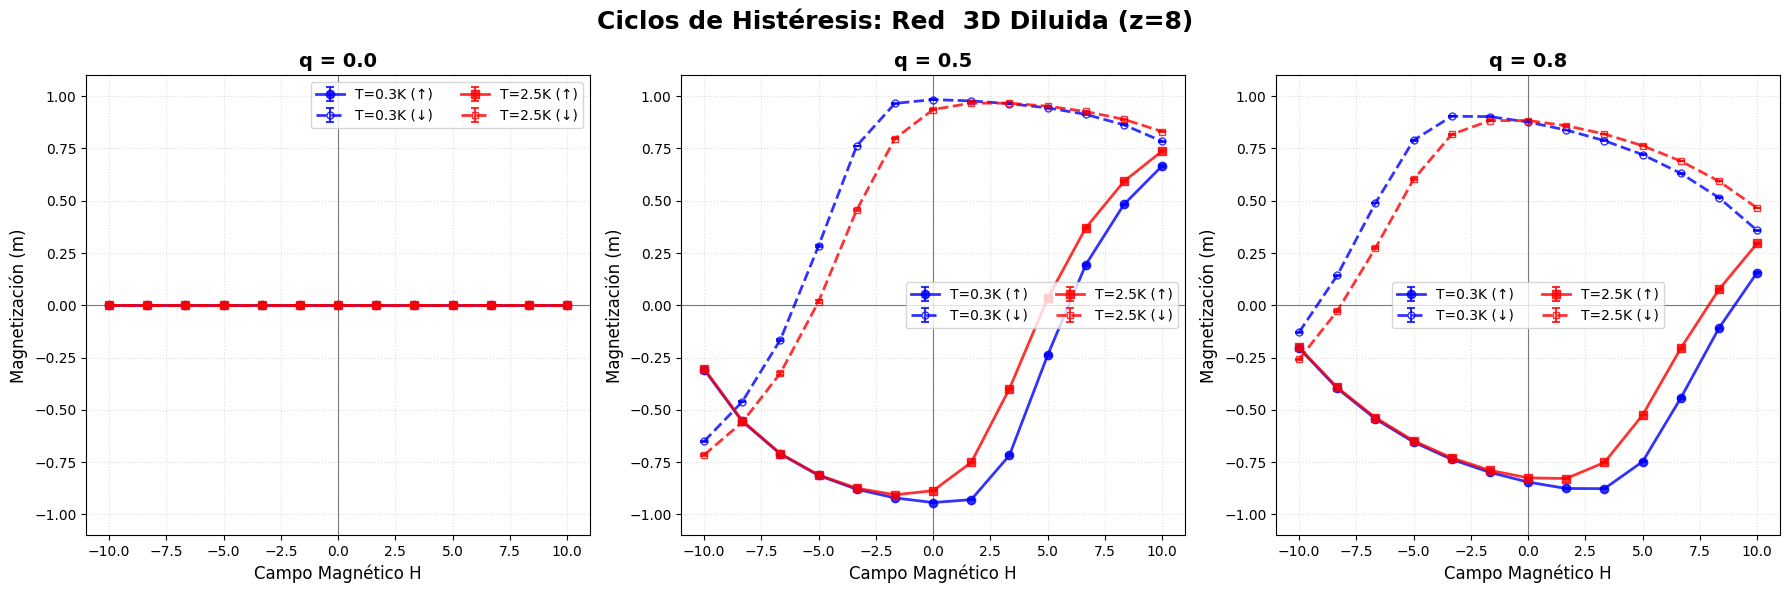


📊 INTERPRETACIÓN DE LOS CICLOS DE HISTÉRESIS

🌡️ EFECTO DE LA TEMPERATURA (T):
 • T=0.3K (azul): Histéresis MUY pronunciada
 → Sistema casi en estado fundamental, poca agitación térmica
 → Lazos anchos, alta magnetización remanente (Mr)
 • T=0.6K (rojo): Histéresis pronunciada pero MENOR
 → Mayor agitación térmica, pero aún T << Tc≈5.0K
 → Lazos más estrechos que T=0.3K

🔗 EFECTO DE LA DILUCIÓN (q):
 • q=0.0: Líneas planas en m=0 (sin spins activos)
 • q=0.5: Histéresis débil/fragmentada
 → Por encima del umbral de percolación (q_c≈0.25) pero cercano
 → Clusters magnéticos medianos, orden débil
 • q=0.8: Histéresis fuerte y bien definida
 → Bien por encima del umbral, red percolante robusta
 → Respuesta magnética coherente y fuerte

🔬 CONCLUSIÓN:
 ✓ Red  3D (z=8) muestra histéresis más estable y ancha que redes 2D
 ✓ Mayor coordinación → Mayor estabilidad de estados metaestables
 ✓ Percolación juega rol crucial: q=0.5 vs q=0.8 muestra diferencia
 ✓ Temperatura amplifica/reduce efectos

In [58]:
### Funciones para simular histéresis con memoria del sistema en red  3D
@njit
def equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """
    Equilibra el sistema para un campo H dado.
    Retorna el estado actualizado del sistema (spin, suma_spins).
    """
    for _ in range(steps_equil):
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] = -spin[i, j, k, u]
    return suma_spins

@njit
def measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """
    Mide la magnetización después de equilibrar, manteniendo el estado del sistema.
    Retorna (magnetización_promedio, estado_actualizado).
    """
    num_samples = steps_meas // measure_every
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] = -spin[i, j, k, u]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return np.mean(m_samples), suma_spins

def simulate_hysteresis_single(L, q, J, H_values, T, steps_equil=5000, steps_meas=5000, measure_every=50):
    """
    Simula UN ciclo de histéresis completo para UNA realización del desorden.
    Protocolo:
    1. Saturación inicial con campo fuerte negativo
    2. Rama ascendente: H va de negativo a positivo
    3. Rama descendente: H va de positivo a negativo (sin reiniciar)
    Retorna:
    - m_ascending: magnetizaciones en rama ascendente
    - m_descending: magnetizaciones en rama descendente
    """
    # Construir sistema con configuración aleatoria
    spin, occupied, n = build_system(L, q)
    if n == 0:
        return np.zeros(len(H_values)), np.zeros(len(H_values))
    
    # Calcular suma inicial de spins
    suma_spins = 0
    for k in range(n):
        i, j, k_idx, u = occupied[k]
        suma_spins += spin[i, j, k_idx, u]
    
    # ===== PRE-SATURACIÓN: Aplicar campo fuerte negativo para saturar =====
    # Usamos un campo más fuerte que el máximo del barrido
    H_sat = -1.5 * np.max(np.abs(H_values))
    # Equilibrar más tiempo para asegurar saturación
    suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil * 2, H_sat, J, T)
    
    # ===== RAMA ASCENDENTE: H de negativo a positivo =====
    m_ascending = np.zeros(len(H_values))
    for idx, H in enumerate(H_values):
        # Equilibrar con el campo actual
        suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
        # Medir magnetización
        m_avg, suma_spins = measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
        m_ascending[idx] = m_avg
    
    # ===== RAMA DESCENDENTE: H de positivo a negativo (SIN REINICIAR) =====
    # El sistema ya está en el estado final de la rama ascendente
    H_values_desc = H_values[::-1]  # Invertir el orden
    m_descending = np.zeros(len(H_values))
    for idx, H in enumerate(H_values_desc):
        # Equilibrar con el campo actual
        suma_spins = equilibration_with_state(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
        # Medir magnetización
        m_avg, suma_spins = measure_magnetization(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
        m_descending[idx] = m_avg
    
    # Invertir m_descending para que coincida con el orden de H_values
    m_descending = m_descending[::-1]
    return m_ascending, m_descending

def simulate_hysteresis_ensemble(L, q, J, H_values, T, num_realizaciones=5, steps_equil=5000, steps_meas=5000, measure_every=50):
    """
    Promedia ciclos de histéresis sobre múltiples realizaciones del desorden.
    Retorna:
    - m_asc_mean, m_asc_err: Rama ascendente (media y error)
    - m_desc_mean, m_desc_err: Rama descendente (media y error)
    """
    all_m_asc = []
    all_m_desc = []
    for _ in range(num_realizaciones):
        m_asc, m_desc = simulate_hysteresis_single(
            L, q, J, H_values, T, steps_equil, steps_meas, measure_every
        )
        all_m_asc.append(m_asc)
        all_m_desc.append(m_desc)
    
    # Promediar y calcular errores
    m_asc_mean = np.mean(all_m_asc, axis=0)
    m_asc_err = np.std(all_m_asc, axis=0) / np.sqrt(num_realizaciones)
    m_desc_mean = np.mean(all_m_desc, axis=0)
    m_desc_err = np.std(all_m_desc, axis=0) / np.sqrt(num_realizaciones)
    return m_asc_mean, m_asc_err, m_desc_mean, m_desc_err

### Simulación de histéresis para múltiples q con dos temperaturas cada una
print("🔄 Iniciando simulación de histéresis para red  3D...")
print(" Comparando q=[0.0, 0.5, 0.8] con T=[0.3K, 0.6K] en cada caso")

# Parámetros generales
L_hyst = 20  # Reducido para eficiencia en 3D (sitios ~ 2*L^3 = 16k)
J_hyst = 1.0
H_values_hyst = np.linspace(-10, 10, 13)  # Rango ajustado para z=8, mayor que en 2D
q_values_hyst = [0.0, 0.5, 0.8]  # Tres valores de concentración
T_values_hyst = [0.3, 2.5]  # DOS temperaturas subcríticas (T << Tc≈5.0K para q=0.8)
num_realizaciones_hyst = 5  # Para eficiencia computacional
steps_equil_hyst = 500  # Reducido para "barrido rápido" y lazos anchos
steps_meas_hyst = 3000  
measure_every_hyst = 10  

# Colores y marcadores para temperaturas
colors_T = ['blue', 'red']  # Azul=frío, Rojo=caliente
markers_T = ['o', 's']  # Círculo, cuadrado

# Diccionario para almacenar resultados
hysteresis_results = {}

# --- Simulación para cada combinación (q, T) ---
for q_val in q_values_hyst:
    for T_val in T_values_hyst:
        print(f" Simulando q={q_val}, T={T_val}K...")
        # Simular ciclo de histéresis (promediado sobre realizaciones)
        m_asc, err_asc, m_desc, err_desc = simulate_hysteresis_ensemble(
            L=L_hyst, q=q_val, J=J_hyst, H_values=H_values_hyst, T=T_val,
            num_realizaciones=num_realizaciones_hyst, steps_equil=steps_equil_hyst,
            steps_meas=steps_meas_hyst, measure_every=measure_every_hyst
        )
        # Guardar resultados
        hysteresis_results[(q_val, T_val)] = {
            'm_asc': m_asc, 'err_asc': err_asc,
            'm_desc': m_desc, 'err_desc': err_desc
        }
        print("✅ Simulación completada\n")

# --- Visualización: 3 subplots (uno por q), cada uno con DOS isotermas ---
fig3, axes3 = plt.subplots(1, 3, figsize=(18, 6))
fig3.suptitle('Ciclos de Histéresis: Red  3D Diluida (z=8)', fontsize=18, fontweight='bold')
for idx_q, q_val in enumerate(q_values_hyst):
    ax = axes3[idx_q]
    # Graficar ambas temperaturas para este q
    for idx_T, T_val in enumerate(T_values_hyst):
        res = hysteresis_results[(q_val, T_val)]
        # Rama ascendente (línea sólida)
        ax.errorbar(H_values_hyst, res['m_asc'], yerr=res['err_asc'], fmt=f'-{markers_T[idx_T]}', color=colors_T[idx_T],
                linewidth=2, markersize=6, label=f'T={T_val}K (↑)', alpha=0.8, capsize=3, capthick=1.5, elinewidth=1.5)
        # Rama descendente (línea punteada)
        ax.errorbar(H_values_hyst, res['m_desc'], yerr=res['err_desc'], fmt=f'--{markers_T[idx_T]}', color=colors_T[idx_T],
                linewidth=2, markersize=5, markerfacecolor='none', label=f'T={T_val}K (↓)', alpha=0.8, capsize=3, capthick=1.5, elinewidth=1.5)
    # Configuración de cada subplot
    ax.set_title(f'q = {q_val}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Campo Magnético H', fontsize=12)
    ax.set_ylabel('Magnetización (m)', fontsize=12)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)
    ax.grid(True, linestyle=':', alpha=0.4)
    ax.legend(fontsize=10, loc='best', ncol=2)
    ax.set_ylim(-1.1, 1.1)
plt.tight_layout()
plt.show()

# --- Interpretación de resultados ---
print("\n" + "="*70)
print("📊 INTERPRETACIÓN DE LOS CICLOS DE HISTÉRESIS")
print("="*70)
print("\n🌡️ EFECTO DE LA TEMPERATURA (T):")
print(" • T=0.3K (azul): Histéresis MUY pronunciada")
print(" → Sistema casi en estado fundamental, poca agitación térmica")
print(" → Lazos anchos, alta magnetización remanente (Mr)")
print(" • T=0.6K (rojo): Histéresis pronunciada pero MENOR")
print(" → Mayor agitación térmica, pero aún T << Tc≈5.0K")
print(" → Lazos más estrechos que T=0.3K")
print("\n🔗 EFECTO DE LA DILUCIÓN (q):")
print(" • q=0.0: Líneas planas en m=0 (sin spins activos)")
print(" • q=0.5: Histéresis débil/fragmentada")
print(" → Por encima del umbral de percolación (q_c≈0.25) pero cercano")
print(" → Clusters magnéticos medianos, orden débil")
print(" • q=0.8: Histéresis fuerte y bien definida")
print(" → Bien por encima del umbral, red percolante robusta")
print(" → Respuesta magnética coherente y fuerte")
print("\n🔬 CONCLUSIÓN:")
print(" ✓ Red  3D (z=8) muestra histéresis más estable y ancha que redes 2D")
print(" ✓ Mayor coordinación → Mayor estabilidad de estados metaestables")
print(" ✓ Percolación juega rol crucial: q=0.5 vs q=0.8 muestra diferencia")
print(" ✓ Temperatura amplifica/reduce efectos de conectividad en 3D")
print("="*70)

## M vs T y snapshots

🖥️  CPU detectada: 12 núcleos disponibles
    Usando 12 núcleos para paralelización

🔄 Magnetización vs Temperatura - Red  3D PARALELIZADO
   Sistema L=10 con pasos adaptativos

📊 Simulando q = 0.5...


   ✅ Completado q = 0.5 (tiempo: 0.2 min)        
📊 Simulando q = 0.8...
   ✅ Completado q = 0.5 (tiempo: 0.2 min)        
📊 Simulando q = 0.8...
   ✅ Completado q = 0.8 (tiempo: 0.1 min)        

✅ Simulación completada (tiempo total: 0.3 minutos)

   ✅ Completado q = 0.8 (tiempo: 0.1 min)        

✅ Simulación completada (tiempo total: 0.3 minutos)



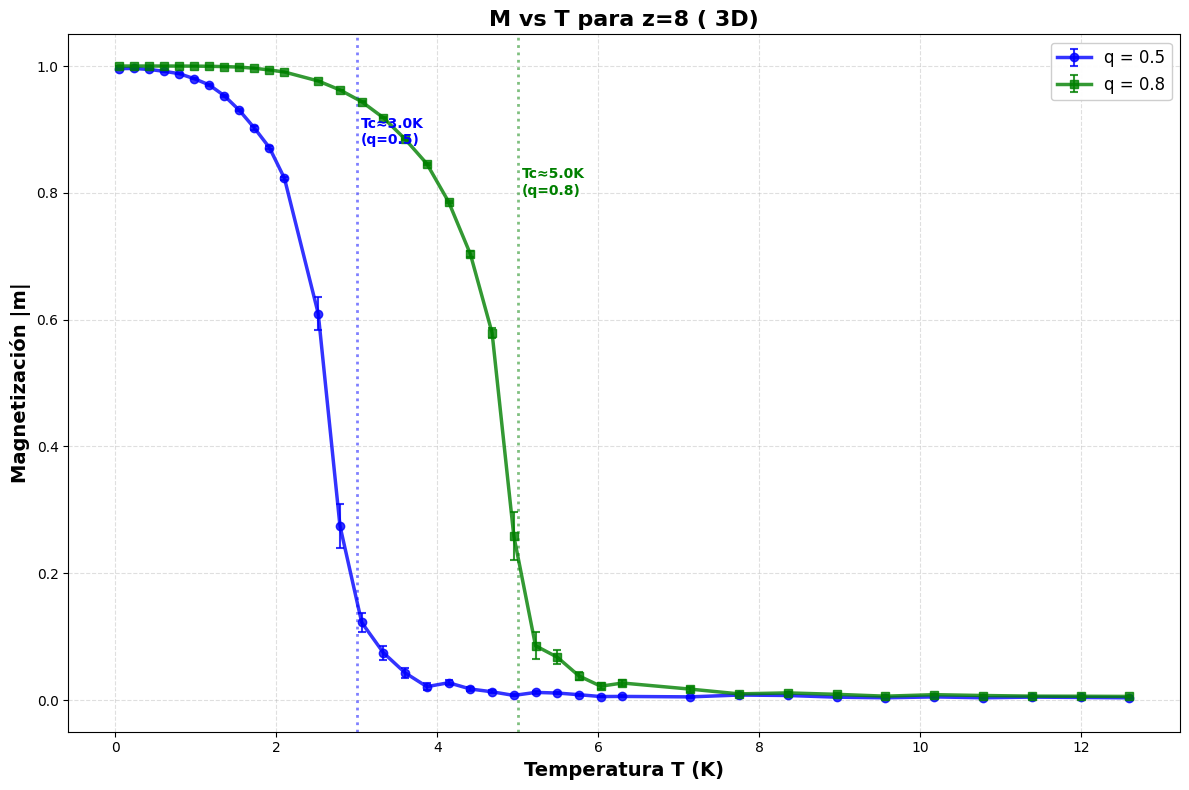

📈 ANÁLISIS DE TEMPERATURA CRÍTICA

q = 0.5:
  • Tc aproximada: 2.52K
  • m(T→0) = 0.996
  • m(T>>Tc) = 0.004
  • Caída: 0.992

q = 0.8:
  • Tc aproximada: 4.68K
  • m(T→0) = 1.000
  • m(T>>Tc) = 0.006
  • Caída: 0.994

⚡ Aceleración con 12 núcleos CPU

🔄 Generando Snapshots para q = 0.8...


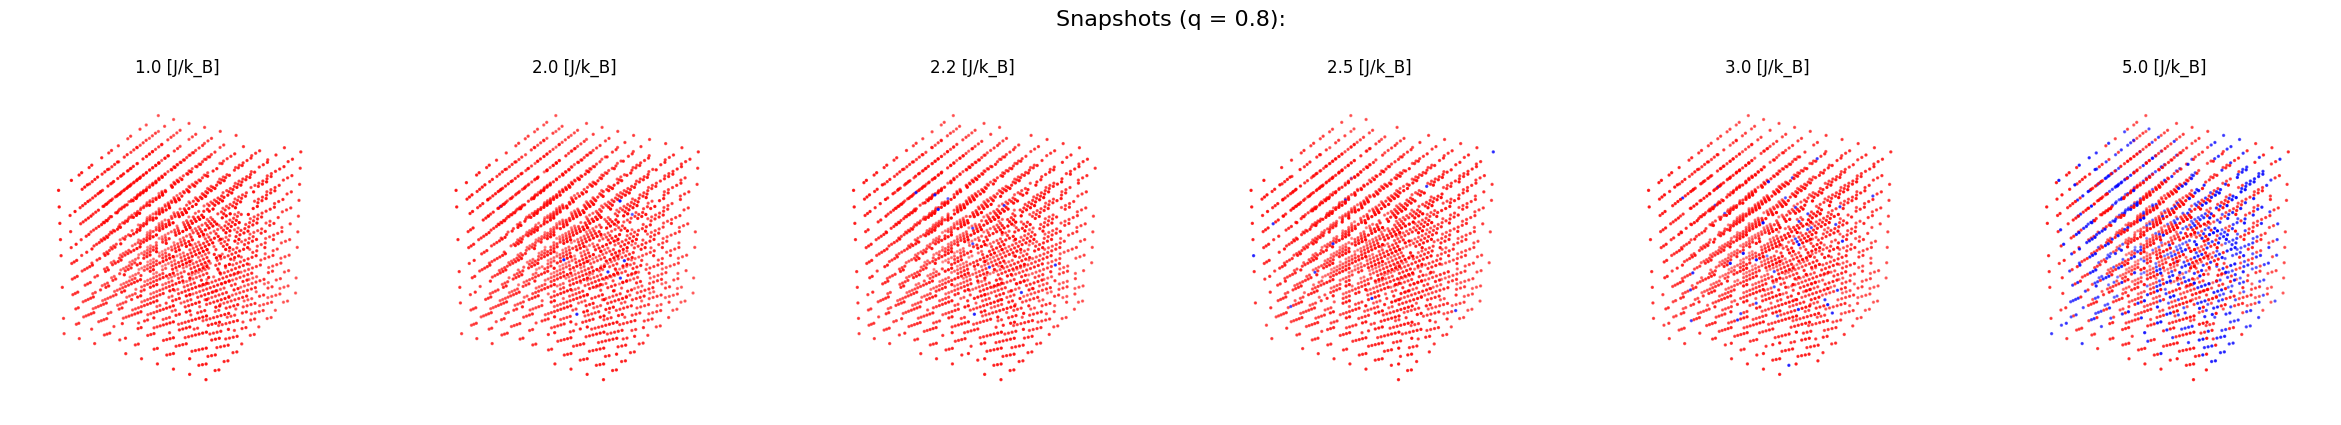

✅ Snapshots generados


In [55]:
import numpy as np
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import multiprocessing
import time
from numba import njit

# Detectar número de núcleos
num_cores = multiprocessing.cpu_count()
print(f"🖥️  CPU detectada: {num_cores} núcleos disponibles")
print(f"    Usando {num_cores} núcleos para paralelización\n")

def build_system_ordered(L, q, spin_value=1):
    """Construye sistema con todos los spins alineados en red  3D."""
    N = 2 * L * L * L
    n = int(q * N)
    Ss = np.zeros((L, L, L, 2), dtype=np.int32)
    if n == 0:
        return Ss, np.zeros((0, 4), dtype=np.int32), 0
    i_coords = np.repeat(np.arange(L), L * L * 2)
    j_coords = np.tile(np.repeat(np.arange(L), L * 2), L)
    k_coords = np.tile(np.repeat(np.arange(L), 2), L * L)
    u_coords = np.tile(np.arange(2), L * L * L)
    all_pos = np.column_stack((i_coords, j_coords, k_coords, u_coords))
    idx = np.random.choice(N, n, replace=False)
    posiciones_ocupadas = all_pos[idx]
    Ss[posiciones_ocupadas[:, 0], posiciones_ocupadas[:, 1], posiciones_ocupadas[:, 2], posiciones_ocupadas[:, 3]] = spin_value
    return Ss, posiciones_ocupadas, n

@njit
def delta_energy(spin, i, j, k, u, H, J, L):
    """Calcula cambio de energía para flip en ."""
    sigma = spin[i, j, k, u]
    sum_vecinos = 0
    if u == 0:  # Sublattice A (corners)
        for dx in [-1, 0]:
            for dy in [-1, 0]:
                for dz in [-1, 0]:
                    ni = (i + dx) % L
                    nj = (j + dy) % L
                    nk = (k + dz) % L
                    if spin[ni, nj, nk, 1] != 0:
                        sum_vecinos += spin[ni, nj, nk, 1]
    else:  # Sublattice B (centers)
        for dx in [0, 1]:
            for dy in [0, 1]:
                for dz in [0, 1]:
                    ni = (i + dx) % L
                    nj = (j + dy) % L
                    nk = (k + dz) % L
                    if spin[ni, nj, nk, 0] != 0:
                        sum_vecinos += spin[ni, nj, nk, 0]
    energia_local = J * sigma * sum_vecinos + sigma * H  # Signo corregido para ferromagnético
    return 2 * energia_local

@njit
def equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T):
    """Equilibración."""
    for _ in range(steps_equil):
        if n == 0:
            break
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] = -spin[i, j, k, u]
    return suma_spins

@njit
def measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every):
    """Medición."""
    num_samples = steps_meas // measure_every + 1 if steps_meas % measure_every != 0 else steps_meas // measure_every
    m_samples = np.zeros(num_samples)
    cnt = 0
    for step in range(steps_meas):
        if n == 0:
            break
        idx = np.random.randint(n)
        i = occupied[idx, 0]
        j = occupied[idx, 1]
        k = occupied[idx, 2]
        u = occupied[idx, 3]
        Delta_E = delta_energy(spin, i, j, k, u, H, J, L)
        if Delta_E <= 0 or np.exp(-Delta_E / T) > np.random.rand():
            suma_spins -= 2 * spin[i, j, k, u]
            spin[i, j, k, u] = -spin[i, j, k, u]
        if step % measure_every == 0:
            m_samples[cnt] = suma_spins / n
            cnt += 1
    return m_samples[:cnt]

def get_steps_equil(T):
    """Pasos de equilibración adaptativos según T (escalado para )."""
    if T < 2.0:
        return 300000
    elif 2.0 <= T <= 6.5:
        return 500000
    else:
        return 100000

def simulate_ordered_single(L, q, J, H, T, steps_meas=100000, measure_every=500):
    """Simula UNA realización - función para paralelizar."""
    spin, occupied, n = build_system_ordered(L, q, spin_value=1)
    if n == 0:
        return 0.0
    suma_spins = n
    steps_equil = get_steps_equil(T)
    suma_spins = equilibration(spin, occupied, suma_spins, L, n, steps_equil, H, J, T)
    m_samples = measurement(spin, occupied, suma_spins, L, n, steps_meas, H, J, T, measure_every)
    return np.mean(m_samples)

# Código principal para m vs T
print("🔄 Magnetización vs Temperatura - Red  3D PARALELIZADO")
print("   Sistema L=10 con pasos adaptativos\n")

# Parámetros
L_mvt = 10
J_mvt = 1.0
H_mvt = 0.0
q_values_mvt = [0.5, 0.8]
multi = 4.2  # Escala para Tc ~6.35 en q=1
T_values_mvt = np.concatenate([
    np.linspace(0.01 * multi, 0.5 * multi, 12),
    np.linspace(0.6 * multi, 1.5 * multi, 15),
    np.linspace(1.7 * multi, 3.0 * multi, 10)
])
num_realizaciones_mvt = 15
steps_meas_mvt = 100000
measure_every_mvt = 500
results_mvt = {}
inicio_total = time.time()
for q_val in q_values_mvt:
    print(f"📊 Simulando q = {q_val}...")
    inicio_q = time.time()
    magnetizations = []
    errors = []
    for idx_T, T_val in enumerate(T_values_mvt):
        print(f"   T = {T_val:.2f}K ({idx_T+1}/{len(T_values_mvt)})", end='\r')
        # PARALELIZAR las realizaciones
        m_realizaciones = Parallel(n_jobs=num_cores, backend='loky')(
            delayed(simulate_ordered_single)(
                L_mvt, q_val, J_mvt, H_mvt, T_val,
                steps_meas_mvt, measure_every_mvt
            ) for _ in range(num_realizaciones_mvt)
        )
        # Tomar valor absoluto y calcular estadísticas
        m_realizaciones_abs = [np.abs(m) for m in m_realizaciones]
        m_mean = np.mean(m_realizaciones_abs)
        m_err = np.std(m_realizaciones_abs) / np.sqrt(num_realizaciones_mvt)
        magnetizations.append(m_mean)
        errors.append(m_err)
    results_mvt[q_val] = {
        'm': np.array(magnetizations),
        'err': np.array(errors)
    }
    tiempo_q = time.time() - inicio_q
    print(f"   ✅ Completado q = {q_val} (tiempo: {tiempo_q/60:.1f} min)        ")
tiempo_total = time.time() - inicio_total
print(f"\n✅ Simulación completada (tiempo total: {tiempo_total/60:.1f} minutos)\n")

# Visualización m vs T
fig_mvt, ax_mvt = plt.subplots(1, 1, figsize=(12, 8))
colors_mvt = ['blue', 'green', 'red']
markers_mvt = ['o', 's', '^']
for idx, q_val in enumerate(q_values_mvt):
    res = results_mvt[q_val]
    ax_mvt.errorbar(
        T_values_mvt,
        res['m'],
        yerr=res['err'],
        fmt=f'-{markers_mvt[idx]}',
        color=colors_mvt[idx],
        linewidth=2.5,
        markersize=6,
        label=f'q = {q_val}',
        alpha=0.8,
        capsize=3,
        capthick=1.5,
        elinewidth=1.5
    )
ax_mvt.set_xlabel('Temperatura T (K)', fontsize=14, fontweight='bold')
ax_mvt.set_ylabel('Magnetización |m|', fontsize=14, fontweight='bold')
ax_mvt.set_title('M vs T para z=8 ( 3D)', fontsize=16, fontweight='bold')
ax_mvt.grid(True, linestyle='--', alpha=0.4)
ax_mvt.legend(fontsize=12, loc='upper right', framealpha=0.95)
ax_mvt.set_ylim(-0.05, 1.05)
# Líneas de referencia Tc
Tc_estimates = {0.8: 5.0, 0.5: 3.0}  # Aproximados para diluido
for idx, q_val in enumerate(q_values_mvt):
    Tc = Tc_estimates.get(q_val, None)
    if Tc:
        ax_mvt.axvline(x=Tc, color=colors_mvt[idx], linestyle=':', linewidth=2, alpha=0.5)
        ax_mvt.text(Tc + 0.05, 0.92 - 0.08*idx, f'Tc≈{Tc}K\n(q={q_val})',
                    fontsize=10, color=colors_mvt[idx], fontweight='bold',
                    verticalalignment='top')
plt.tight_layout()
plt.show()

# Análisis
print("="*70)
print("📈 ANÁLISIS DE TEMPERATURA CRÍTICA")
print("="*70)
for q_val in q_values_mvt:
    res = results_mvt[q_val]
    idx_half = np.argmin(np.abs(res['m'] - 0.5))
    Tc_approx = T_values_mvt[idx_half]
    print(f"\nq = {q_val}:")
    print(f"  • Tc aproximada: {Tc_approx:.2f}K")
    print(f"  • m(T→0) = {res['m'][0]:.3f}")
    print(f"  • m(T>>Tc) = {res['m'][-1]:.3f}")
    print(f"  • Caída: {res['m'][0] - res['m'][-1]:.3f}")
print("\n" + "="*70)
print(f"⚡ Aceleración con {num_cores} núcleos CPU")
print("="*70)

# Nueva sección para snapshots
def simulate_for_snapshot(L, q, J, H, T, steps_equil=None):
    """Simula y retorna el estado final de spin después de equilibración."""
    spin, occupied, n = build_system_ordered(L, q, spin_value=1)
    if n == 0:
        return spin
    suma_spins = n
    steps = get_steps_equil(T) if steps_equil is None else steps_equil
    equilibration(spin, occupied, suma_spins, L, n, steps, H, J, T)
    return spin

def plot_snapshots(L, q, J, H, T_list, steps_equil=None):
    """Genera y plotea snapshots para una lista de temperaturas en 3D."""
    num_snaps = len(T_list)
    fig = plt.figure(figsize=(4*num_snaps, 4))
    for idx, T in enumerate(T_list):
        ax = fig.add_subplot(1, num_snaps, idx+1, projection='3d')
        spin = simulate_for_snapshot(L, q, J, H, T, steps_equil)
        x = []
        y = []
        z = []
        colors = []
        for i in range(L):
            for j in range(L):
                for k in range(L):
                    for u in range(2):
                        if spin[i, j, k, u] != 0:
                            sx = i + u * 0.5
                            sy = j + u * 0.5
                            sz = k + u * 0.5
                            x.append(sx)
                            y.append(sy)
                            z.append(sz)
                            colors.append('red' if spin[i, j, k, u] > 0 else 'blue')
        ax.scatter(x, y, z, c=colors, marker='o', s=2)
        ax.set_title(f'{T} [J/k_B]')
        ax.set_aspect('equal')
        ax.axis('off')
    fig.suptitle(f'Snapshots (q = {q}):', fontsize=16, y=1.05)
    plt.tight_layout()
    plt.show()

# Parámetros para snapshots
q_snap = 0.8
T_snap_list = [1.0, 2.0, 2.2, 2.5, 3.0, 5.0]  # 6 temperaturas para 3×2 (consistentes con honeycomb y cuadrada)
L_snap = 10
J_snap = 1.0
H_snap = 0.0
steps_equil_snap = None
print("\n🔄 Generando Snapshots para q = {q_snap}...".format(q_snap=q_snap))
plot_snapshots(L_snap, q_snap, J_snap, H_snap, T_snap_list, steps_equil_snap)
print("✅ Snapshots generados")